# Labs Works 1+2 Alexis Carbillet

In [1]:
#import des librairies
import numpy as np
import pandas
from dateutil.parser import parse
import datetime
import pytz
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet, stopwords
import re
import string
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
import warnings

In [2]:
warnings.filterwarnings('ignore')
## import dataset
# train
train = pandas.read_csv('Train.csv')
# test
test=pandas.read_csv('Test.csv')

The functions below are used for the processing of the tweets.

In [3]:
def to_datetime(datestring):
    time_tuple = parsedate_tz(datestring.strip())
    dt = datetime(*time_tuple[:6])
    return dt - timedelta(seconds=time_tuple[-1])

# text processing
def isSymbol(inputString):
    return bool(re.match(r'[^\w]', inputString))
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))

wordnet_lemmatizer = WordNetLemmatizer()

stop = stopwords.words('english')
stop2 = stopwords.words('spanish')
stop3 = stopwords.words('portuguese')
stop4 = stopwords.words('arabic')

def check(word):

    word= word.lower()
    if word in stop:
        return False
    elif word in stop2:
        return False
    elif word in stop3:
        return False
    elif word in stop4:
        return False
    elif hasNumbers(word) or isSymbol(word):
        return False
    else:
        return True


def preprocessing(sen):
    res = []
    for word in sen:
        if check(word):
            res.append(wordnet_lemmatizer.lemmatize(word))
    return res

def in_dict(word):
    if wordnet.synsets(word,lang='eng'):
        return True
    if wordnet.synsets(word,lang='spa'):
        return True
    if wordnet.synsets(word,lang='por'):
        return True
    if wordnet.synsets(word,lang='jpn'):
        return True
    if wordnet.synsets(word,lang='arb'):
        return True

def replace_elongated_word(word):
    regex = r'(\w*)(\w+)\2(\w*)'
    repl = r'\1\2\3'    
    if in_dict(word):
        return word
    new_word = re.sub(regex, repl, word)
    if new_word != word:
        return replace_elongated_word(new_word)
    else:
        return new_word

def detect_elongated_words(row):
    regexrep = r'(\w*)(\w+)(\2)(\w*)'
    words = [''.join(i) for i in re.findall(regexrep, row)]
    for word in words:
        if not in_dict(word):
            row = re.sub(word, replace_elongated_word(word), row)
    return row

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)


def getStringBigrams(string):
    if len(string) <= 0: return []
    if len(string) == 1: return string[0] # Handle strings with only one character = extract unigram
    return [string[i]+string[i+1] for i in range(len(string)-1)]

def getDataBigrams(strings):
    return [getStringBigrams(x) for x in strings]

def generateDictionary(data):
    '''
    This function identifies unique n-grams in your data.
    '''
    vocab = set()
    for line in data:
        for item in line:
            vocab.add(item)
    dictionary = {}
    i=0
    for item in vocab:
        dictionary[item] = i
        i+=1
    return dictionary

def doc2Bow(bigramData, dictionary):
    ''' 
    Take single document in bigram format and return a vector
    '''
    vect = [0]*len(dictionary) # Initialize vector to zero
    for gram in bigramData:
        vect[dictionary[gram]]+=1
    return np.asarray(vect)  # Convert to numpy vector

Now the others columns will be processed with those functions:

In [4]:
def topicProcessing(data):
    for i in range(data.shape[0]):
        dt = data[i]
        if(dt=='twitter'):
            data[i]=np.int64(1)
        if(dt=='apple'):
            data[i]=np.int64(2)
        if(dt=='google'):
            data[i]=np.int64(3)
        if(dt=='microsoft'):
            data[i]=np.int64(4)

def sentimentProcessing(data):
    for i in range(data.shape[0]):
        dt = data[i]
        if(dt=='positive'):
            data[i]=1
        if(dt=='neutral'):
            data[i]=0
        if(dt=='negative'):
            data[i]=-1
        if(dt=='irrelevant'):
            data[i]=-10

def dateProcessing(train):
    for i in range(train.shape[0]):
        dt = parse(train['TweetDate'][i])
        train['TweetDate'][i]=(dt-datetime.datetime(1970,1,1,tzinfo=pytz.utc)).total_seconds() # convert to int
    text_merge=""

Now there is the machine learning :

In [5]:
def fit(nb,train,test,y,yt,height,height_f1,type):
    nb.fit(train, y)
    w=nb.score(test, yt)
    z=f1_score(yt, nb.predict(test),average='weighted')
    height.append(w)
    height_f1.append(z)

def ml(train,test,y,yt,time,subject):
    height=[]
    height_f1=[]
    bars=['bayes','perceptron','MLP','tree','logistic regression','kNN 3 neighbors','kNN 7 neighbors','kNN 15 neighbors','SVC','Random Forest']
    # bayes
    nb = MultinomialNB()
    fit(nb,train,test,y,yt,height,height_f1,'bayes')
    # perceptron
    nb = Perceptron(tol=1e-3, random_state=0)
    fit(nb,train,test,y,yt,height,height_f1,'perceptron')
    # multi-layer perceptron
    nb = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    fit(nb,train,test,y,yt,height,height_f1,'multi-layer perceptron')
    # tree classifier
    nb = DecisionTreeClassifier(random_state=0)
    fit(nb,train,test,y,yt,height,height_f1,'tree')
    # logistic regression
    nb =LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
    fit(nb,train,test,y,yt,height,height_f1,'logistic regression')
    # kNN 3
    nb = KNeighborsClassifier(n_neighbors=3)
    fit(nb,train,test,y,yt,height,height_f1,'kNN 3 neighbors')
    # kNN 7
    nb = KNeighborsClassifier(n_neighbors=7)
    fit(nb,train,test,y,yt,height,height_f1,'kNN 7 neighbors')
    # kNN 15
    nb = KNeighborsClassifier(n_neighbors=15)
    fit(nb,train,test,y,yt,height,height_f1,'kNN 15 neighbors')
    # SVC
    nb = SVC(gamma='auto')
    fit(nb,train,test,y,yt,height,height_f1,'SVC')
    # random forest
    nb = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    fit(nb,train,test,y,yt,height,height_f1,'random forest')
    y_pos = np.arange(len(bars))
    plt.figure()
    # title1='Mean accuracy for sentiment prediction:'
    # plt.title(title1)
    # plt.bar(y_pos, height)  # Create bars
    # plt.xticks(y_pos, bars, rotation=90) # Create names on the x-axis
    # plt.subplots_adjust(bottom=0.3, top=0.95) # Custom the subplot layout
    # plt.figure()
    title2='F1 score for '+subject+' prediction with time='+time
    plt.title(title2)
    plt.bar(y_pos, height_f1)  # Create bars
    plt.xticks(y_pos, bars, rotation=90) # Create names on the x-axis
    plt.subplots_adjust(bottom=0.3, top=0.95) # Custom the subplot layout
    plt.show()    # Show graphic
    print('the best one for sentiment prediction is ',bars[height_f1.index(max(height_f1))],' with a F1 score of ',height_f1[height_f1.index(max(height_f1))])

The datasets are processed with this function:

In [6]:
def processing(train,test,time):
    # labels recuperation
    labels=train['Sentiment']
    train=train.drop(['Sentiment'],axis=1)
        
    labels_test=test['Sentiment']
    test=test.drop(['Sentiment'],axis=1)

    if(time=='true'):
        # date processing
        dateProcessing(train)
        dateProcessing(test)

    # topic processing
    topicProcessing(train['Topic'])
    topicProcessing(test['Topic'])
    
    # sentiment processing
    sentimentProcessing(labels)
    sentimentProcessing(labels_test)
    
    # text processing
    l=[]
    x=labels.shape[0]
    for i in range(x):
        l.append([])
        a=train['TweetText'][i]
        b=a.encode('ascii','ignore')
        b=b.decode('utf8')
        b=b.lower()
        b=strip_all_entities(strip_links(b))
        puk=TweetTokenizer()
        cleaneded=puk.tokenize(b) # put clean when corrected
        cc=preprocessing(cleaneded)
        for item in cc:
            if len(item)>2: # we don't want to have useless words
                l[i].append(detect_elongated_words(item))
        tempo=' '.join(l[i])
        if len(tempo)>3:
            train['TweetText'][i]=tempo
            
        else: # message useless are deleted
            train['TweetText'][i]=''
            # delete the nul label and its features
            del labels[i]
            train=train.drop(i,axis=0)
            
    l=[]
    x=labels_test.shape[0]
    for i in range(x):
        l.append([])
        a=test['TweetText'][i]
        b=a.encode('ascii','ignore')
        b=b.decode('utf8')
        b=b.lower()
        b=strip_all_entities(strip_links(b))
        puk=TweetTokenizer()
        cleaneded=puk.tokenize(b) # put clean when corrected
        cc=preprocessing(cleaneded)
        for item in cc:
            if len(item)>2: # we don't want to have useless words
                l[i].append(detect_elongated_words(item))
        tempo=' '.join(l[i])
        if len(tempo)>3:
            test['TweetText'][i]=tempo
            
        else: # message useless are deleted
            test['TweetText'][i]=''
            # delete the nul label and its features
            del labels_test[i]
            test=test.drop(i,axis=0)

    ## feature extraction
    # train
    nGramData = getDataBigrams(train['TweetText'])
    dictionary = generateDictionary(nGramData)
    data = [doc2Bow(nGramData[i], dictionary) for i in range(len(nGramData))]
    svd = TruncatedSVD(n_components=100)
    X_reduced = svd.fit_transform(data)
    # test
    nGramData = getDataBigrams(test['TweetText'])
    dictionary = generateDictionary(nGramData)
    data = [doc2Bow(nGramData[i], dictionary) for i in range(len(nGramData))]
    svd = TruncatedSVD(n_components=100)
    X_reduced2 = svd.fit_transform(data)
    
    ## classification sentiment
    # naive bayes
    train['TweetText'] = X_reduced
    test['TweetText'] = X_reduced2
    y=pandas.DataFrame.transpose(pandas.DataFrame([labels])).values.ravel()
    yt=pandas.DataFrame.transpose(pandas.DataFrame([labels_test])).values.ravel()
    ml(train,test,y,yt,time,'sentiment')
    
    ## classification topic
    y2=pandas.DataFrame.transpose(pandas.DataFrame(train['Topic'])).values.ravel()
    yt2=pandas.DataFrame.transpose(pandas.DataFrame(test['Topic'])).values.ravel()
    y2=y2.astype('int')
    yt2=yt2.astype('int')
    train2=train.drop(['Topic'],axis=1)
    test2=test.drop(['Topic'],axis=1)
    ml(train2,test2,y2,yt2,time,'topic')

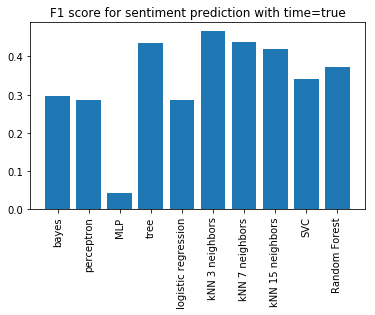

the best one for sentiment prediction is  kNN 3 neighbors  with a F1 score of  0.4659178378204406


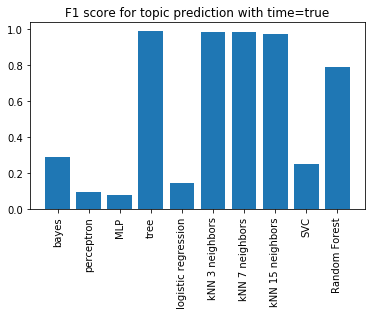

the best one for sentiment prediction is  tree  with a F1 score of  0.9900990099009901


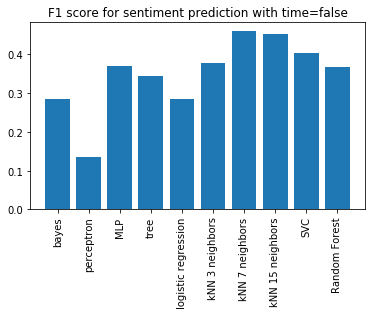

the best one for sentiment prediction is  kNN 7 neighbors  with a F1 score of  0.45955869019351836


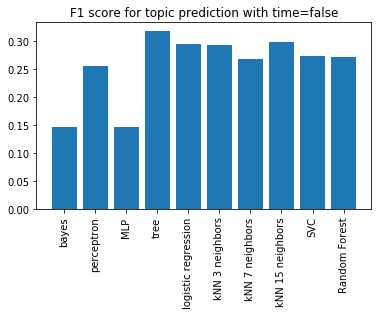

the best one for sentiment prediction is  tree  with a F1 score of  0.3173798098399649


In [7]:
processing(train, test, 'true')
# without the time
test=test.drop(['TweetDate'],axis=1)
train=train.drop(['TweetDate'],axis=1)
processing(train, test, 'false')

To conclude, 10 differents classifiers have been used. According to the results obtained during the test step.
The best classifier for the sentiment prediction is the kNN 3 neighbors  with a F1 score of  0.4659178378204406 with the time column in input and it is the kNN 7 neighbors  with a F1 score of  0.45955869019351836 without the time column in input.

About the topic prediction, with the time column, the best classifier is the tree with a F1 score of  0.9900990099009901 and without the time column, the best classifier is still the tree but with a F1 score of  0.3173798098399649

The time column is very important for the topic prediction. In fact, most tweets about the same topic have been collected in short amount of time. This explains the important influence of this column on the topic prediction.